#Benin EDA

In [1]:
import pandas as pd

df = pd.read_csv("../data/solar-measurements_sierraleone-bumbuna_qc.csv", encoding="latin1")
df.drop(0,axis = 0,inplace=True) #remove the first row becuase it only describes the type of the column's data
df.droplevel
df.head()


/tmp/ipykernel_60764/1604855952.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/solar-measurements_sierraleone-bumbuna_qc.csv", encoding="latin1")


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
1,2021-10-30 00:01,-0.7,-0.1,-0.8,0,0,21.9,99.1,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
2,2021-10-30 00:02,-0.7,-0.1,-0.8,0,0,21.9,99.2,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
3,2021-10-30 00:03,-0.7,-0.1,-0.8,0,0,21.9,99.2,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
4,2021-10-30 00:04,-0.7,0,-0.8,0,0,21.9,99.3,0,0,0,0,0,1002,0,0.1,22.3,22.6,NaN
5,2021-10-30 00:05,-0.7,-0.1,-0.8,0,0,21.9,99.3,0,0,0,0,0,1002,0,0,22.3,22.6,NaN


In [2]:
df.describe()

,Comments
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [3]:
print("Initial data loading successful.")
print(f"Initial DataFrame shape: {df.shape}")

# --- 1. Initial Data Inspection & Preprocessing ---
# Convert 'Timestamp' to datetime objects
df['Timestamp'] = pd.to_datetime(df["Timestamp"])
df = df.set_index('Timestamp') # Set Timestamp as index for time series analysis



Initial data loading successful.
Initial DataFrame shape: (525600, 19)


In [4]:
# df.isna().sum() and list any column with >5% nulls
missing_values = df.isna().sum()
total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100

print("\nMissing Value Report:")
print(missing_values[missing_values > 0]) # Only show columns with missing values
print("\nColumns with >5% Nulls:")
high_null_cols = missing_percentage[missing_percentage > 5]
if not high_null_cols.empty:
    print(high_null_cols)
else:
    print("No columns with more than 5% nulls.")


Missing Value Report:
Comments    525600
dtype: int64

Columns with >5% Nulls:
Comments    100.0
dtype: float64


In [5]:
# since the comments is 100% empty
df.drop(columns=['Comments'], inplace=True)

In [6]:
from scipy.stats import zscore
import numpy as np

# Columns to check for outliers
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
# Convert columns to numeric, coercing errors
for col in columns_to_check:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # After coercion, check if any values became NaN, indicating original non-numeric data
        if df[col].isnull().sum() > 0:
            print(f"  --> After coercing '{col}' to numeric, {df[col].isnull().sum()} values became NaN (were non-numeric).")
    else:
        print(f"  Column '{col}' not found for numeric conversion.")

col = "Tamb"

df[col] = pd.to_numeric(df[col], errors='coerce')
# After coercion, check if any values became NaN, indicating original non-numeric data
if df[col].isnull().sum() > 0:
    print(f"  --> After coercing '{col}' to numeric, {df[col].isnull().sum()} values became NaN (were non-numeric).")


# Store original ModA and ModB for later comparison
df['ModA_original'] = df['ModA']
df['ModB_original'] = df['ModB']
df['Cleaning_Flag'] = 'Original' # Initialize cleaning flag

# Define numerical columns for easier reference later
# Exclude specific columns from `describe` if they are identifiers or flags
# 'Cleaning' column is an int, but more of a flag, so we can consider excluding it if describe is too noisy
numeric_cols_for_describe = [col for col in df.select_dtypes(include=np.number).columns.tolist()
                             if col not in ['Cleaning', 'ModA_original', 'ModB_original']]

In [7]:

# Calculate Z-scores
z_scores = np.abs(df[columns_to_check].apply(zscore))

# Flag rows where any column has a Z-score > 3
outliers = (z_scores > 3).any(axis=1)

# Count and preview
print(f"Number of outlier rows: {outliers.sum()}")
df_outliers = df[outliers]
df_outliers.head()


Number of outlier rows: 16292


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,ModA_original,ModB_original,Cleaning_Flag
Timestamp,,,,,,,,,,,,,,,,,,,,
2021-10-30 10:54:00,814.0,257.0,594.3,878.0,856.0,25.9,85.3,0.5,1.1,0.5,81.4,7.9,1002,0,0,50.4,45.6,878.0,856.0,Original
2021-10-30 10:55:00,826.0,263.5,599.6,883.0,861.0,26.0,85.4,1.7,2.4,0.4,74.6,12.1,1002,0,0,51.6,46.6,883.0,861.0,Original
2021-10-30 10:56:00,851.0,285.0,605.9,912.0,890.0,26.0,84.2,1.6,2.1,0.5,66.4,14.6,1002,0,0,52.4,47,912.0,890.0,Original
2021-10-30 10:57:00,823.0,254.8,603.9,878.0,856.0,26.0,85.3,0.8,1.6,0.6,90.2,7,1002,0,0,53.4,47.7,878.0,856.0,Original
2021-10-30 10:58:00,810.0,244.5,598.8,864.0,843.0,26.1,85.7,0.6,1.6,0.6,108.5,7.9,1002,0,0,54.6,48.6,864.0,843.0,Original


In [8]:
initial_outlier_count = outliers.sum()
print(f"\nTotal unique rows flagged as outliers across all specified columns: {initial_outlier_count}")

# Impute outliers with the median of non-outlier data for each column
if initial_outlier_count > 0:
    for col in outliers:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            # Calculate median from non-outlier data only
            median_for_imputation = df.loc[~outliers, col].median()
            # Apply imputation only to the flagged outlier rows in that specific column
            df.loc[df_outliers, col] = median_for_imputation
            # Also, handle cases where GHI, DNI, DHI, ModA, ModB could be negative or extremely high
            # (e.g., set negative solar values to 0 if they remain after Z-score)
            if col in ['GHI', 'DNI', 'DHI', 'ModA', 'ModB'] and (df.loc[outliers, col] < 0).any():
                 df.loc[outliers & (df[col] < 0), col] = 0
            print(f"  Outliers in '{col}' imputed with median of non-outlier data ({median_for_imputation:.2f}).")
            if col in ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']:
                # Additionally, set any remaining negative solar values to 0 (physical constraint)
                df.loc[df[col] < 0, col] = 0
                print(f"  Ensured '{col}' values are non-negative.")
    df.loc[outliers, 'Cleaning_Flag'] = 'Cleaned'
else:
    print("No rows identified as outliers based on Z-score > 3.")


Total unique rows flagged as outliers across all specified columns: 16292


In [9]:
# Verify if the cleaning was successful
print("\nDescriptive Statistics for key columns after Outlier Imputation:")
print(df[columns_to_check].describe())


Descriptive Statistics for key columns after Outlier Imputation:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB             WS         WSgust  
count  525600.000000  525600.000000  525600.000000  
mean      198.114691       1.146113       1.691606  
std       288.889073       1.239248       1.617053  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000

In [19]:
# Export cleaned DataFrame
import os
output_dir = "../data/"
output_filename = os.path.join(output_dir, "sierraleone-bumbuna_clean.csv")
# Create data directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
df.to_csv(output_filename, index=True) # index=True to save Timestamp
print(f"\nCleaned DataFrame exported to: {output_filename}")


Cleaned DataFrame exported to: ../data/sierraleone-bumbuna_clean.csv



--- 3. Time Series Analysis ---


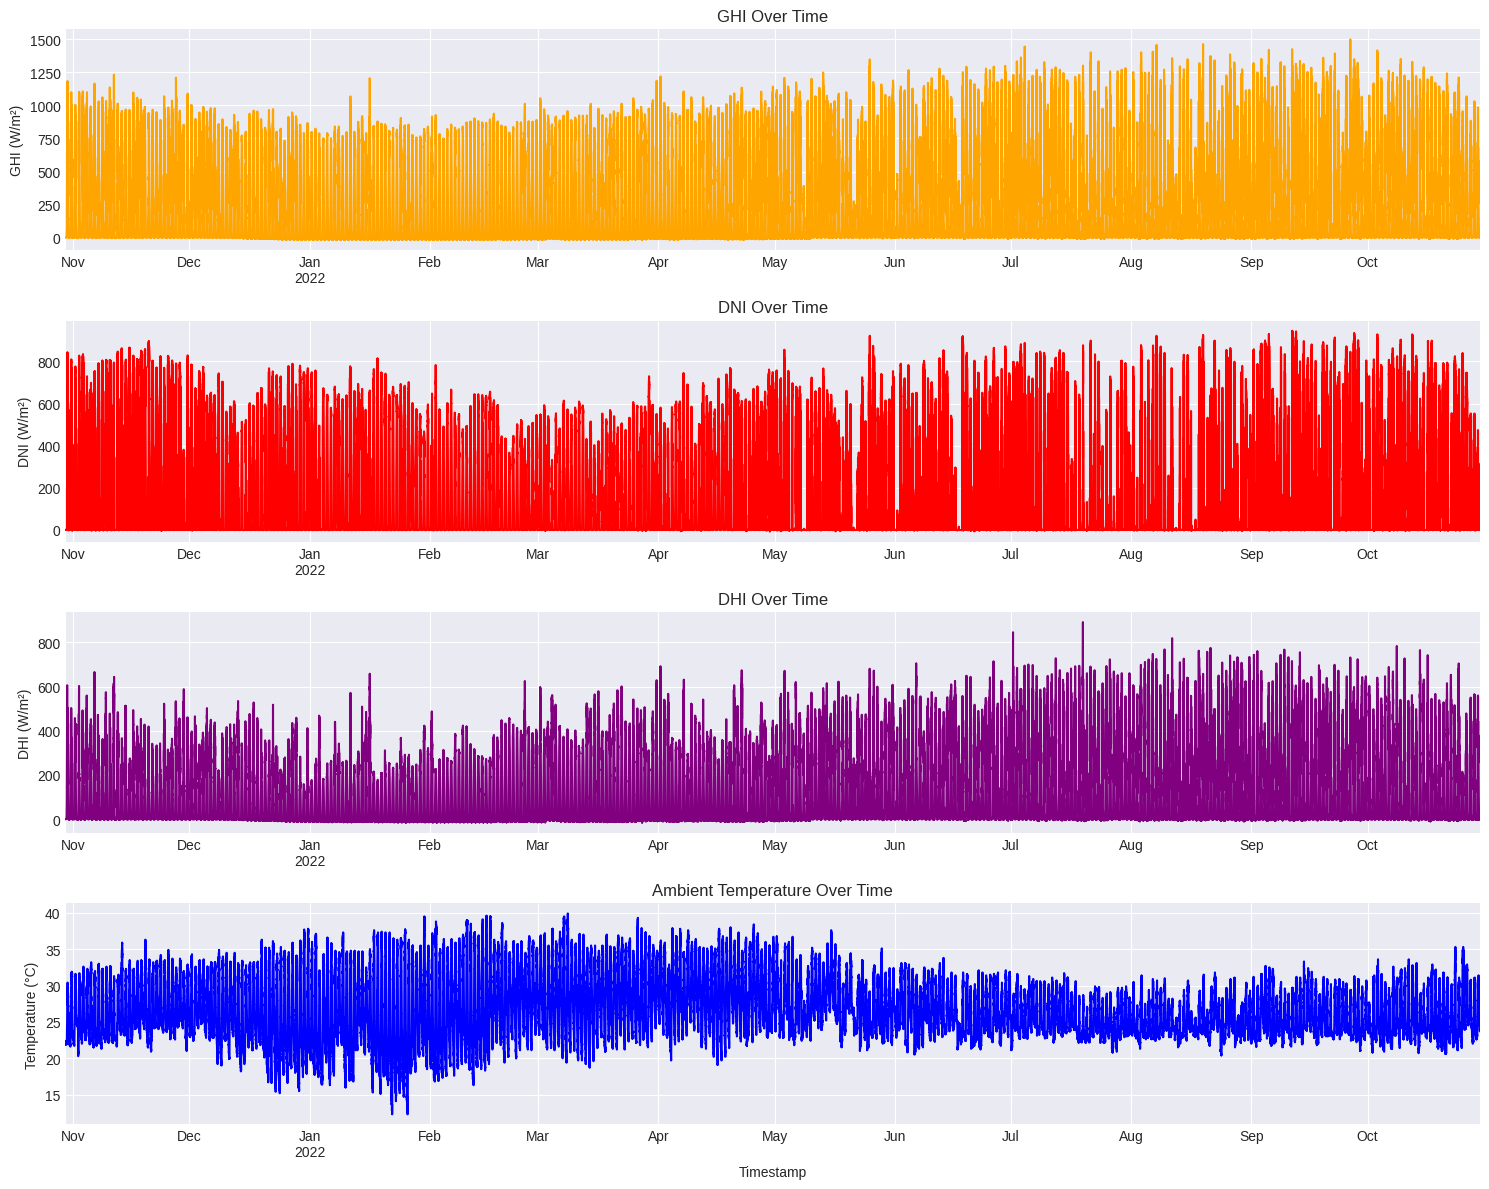

In [11]:
import matplotlib.pyplot as plt
print("\n--- 3. Time Series Analysis ---")


# Define a style for plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(15, 12))

# Plot GHI, DNI, DHI, Tamb vs. Timestamp
plt.subplot(4, 1, 1)
df['GHI'].plot(ax=plt.gca(), title='GHI Over Time', color='orange')
plt.ylabel('GHI (W/m²)')
plt.xlabel('') # Remove x-label for subplots

plt.subplot(4, 1, 2)
df['DNI'].plot(ax=plt.gca(), title='DNI Over Time', color='red')
plt.ylabel('DNI (W/m²)')
plt.xlabel('')

plt.subplot(4, 1, 3)
df['DHI'].plot(ax=plt.gca(), title='DHI Over Time', color='purple')
plt.ylabel('DHI (W/m²)')
plt.xlabel('')

plt.subplot(4, 1, 4)
df['Tamb'].plot(ax=plt.gca(), title='Ambient Temperature Over Time', color='blue')
plt.ylabel('Temperature (°C)')
plt.xlabel('Timestamp')

plt.tight_layout()
plt.show()


Observing patterns:


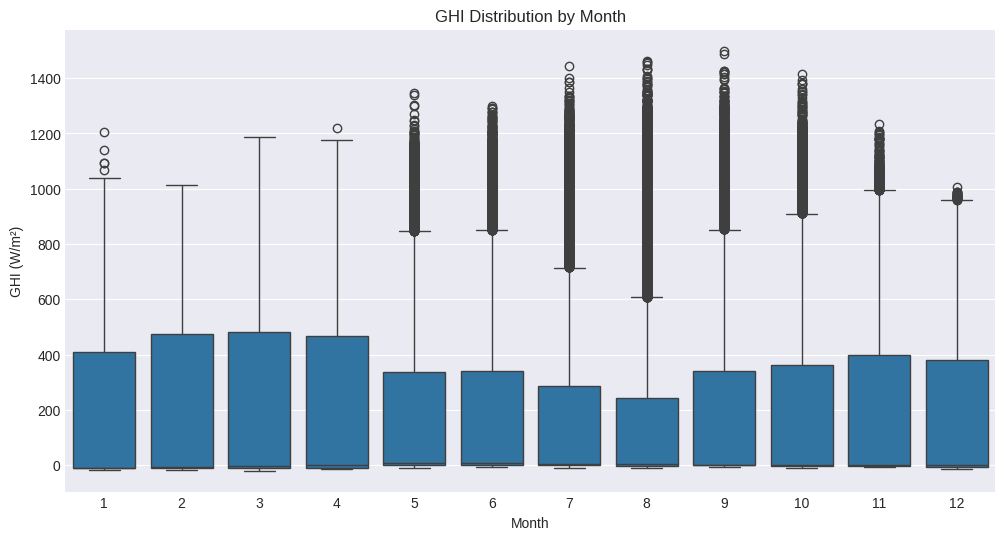

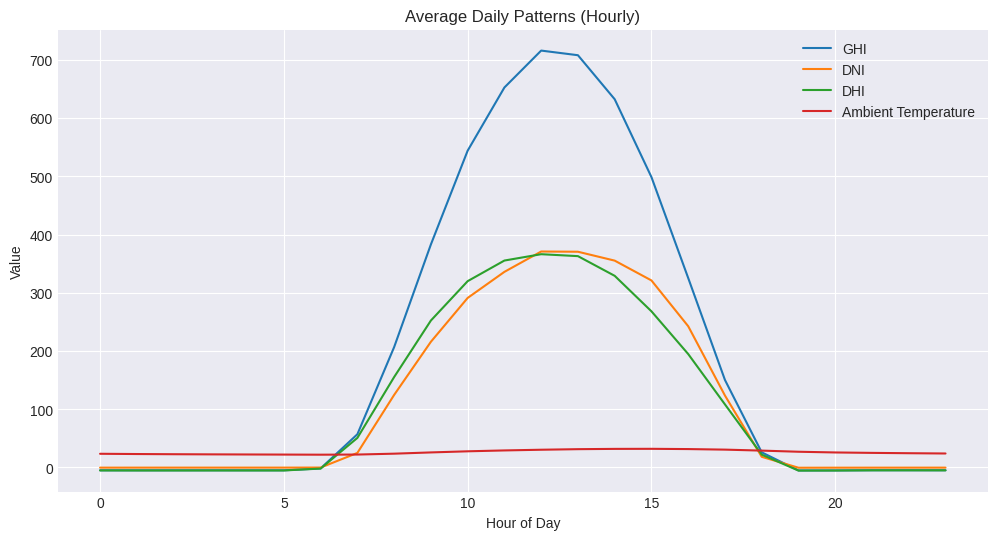

In [12]:
import seaborn as sns
print("\nObserving patterns:")
# Patterns by month
# Ensure 'Month' and 'Hour' are derived from the index if they aren't already
if 'Month' not in df.columns:
    df['Month'] = df.index.month
if 'Hour' not in df.columns:
    df['Hour'] = df.index.hour

plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='GHI', data=df)
plt.title('GHI Distribution by Month')
plt.ylabel('GHI (W/m²)')
plt.xlabel('Month')
plt.show()

# Trends throughout the day (average hourly)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Hour', y='GHI', data=df, errorbar=None, label='GHI')
sns.lineplot(x='Hour', y='DNI', data=df, errorbar=None, label='DNI')
sns.lineplot(x='Hour', y='DHI', data=df, errorbar=None, label='DHI')
sns.lineplot(x='Hour', y='Tamb', data=df, errorbar=None, label='Ambient Temperature')
plt.title('Average Daily Patterns (Hourly)')
plt.ylabel('Value')
plt.xlabel('Hour of Day')
plt.legend()
plt.show()


--- 4. Cleaning Impact ---

Average ModA & ModB Pre/Post Cleaning:
               ModA_original  ModB_original        ModA        ModB
Cleaning_Flag                                                      
Cleaned           734.298355     711.448607  734.298355  711.448607
Original          189.764194     181.693908  189.764194  181.693908


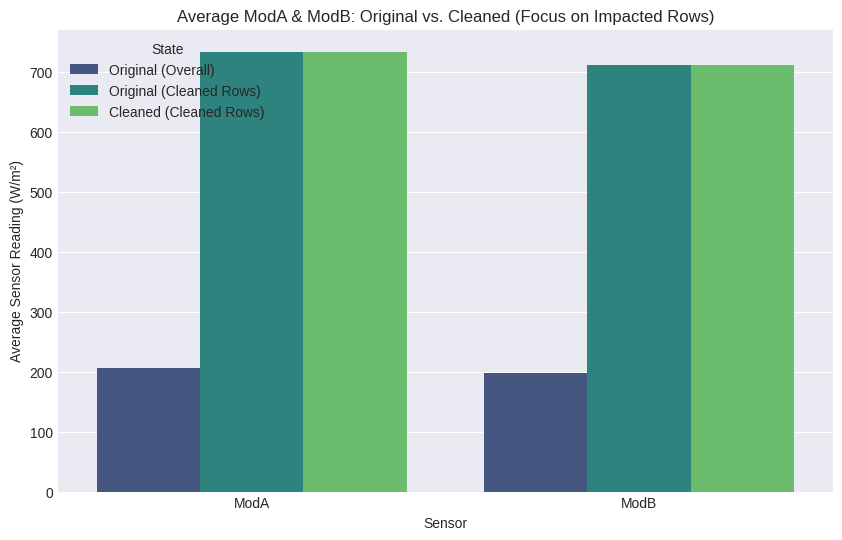

In [13]:
# --- 4. Cleaning Impact ---

print("\n--- 4. Cleaning Impact ---")

# Group by Cleaning_Flag and plot average ModA & ModB pre/post-clean.
# We compare the 'original' columns (ModA_original, ModB_original) with the 'cleaned' ones (ModA, ModB)
# for the rows that were flagged as 'Cleaned'. For 'Original' flag, we just take the ModA_original/ModB_original averages.

avg_mod_pre_post = df.groupby('Cleaning_Flag')[['ModA_original', 'ModB_original', 'ModA', 'ModB']].mean()
print("\nAverage ModA & ModB Pre/Post Cleaning:")
print(avg_mod_pre_post)

# Prepare data for plotting the cleaning impact
# Get the average of original and cleaned values for ModA and ModB
# We need to distinguish between rows that were *actually* cleaned vs. those that were just 'Original'
data_for_plot = []

# For 'Original' data (all rows, using _original columns)
data_for_plot.append({'Metric': 'ModA', 'Value': df['ModA_original'].mean(), 'State': 'Original (Overall)'})
data_for_plot.append({'Metric': 'ModB', 'Value': df['ModB_original'].mean(), 'State': 'Original (Overall)'})

# For 'Cleaned' data (only for the rows that were flagged as 'Cleaned')
if 'Cleaned' in df['Cleaning_Flag'].unique():
    cleaned_df = df[df['Cleaning_Flag'] == 'Cleaned']
    data_for_plot.append({'Metric': 'ModA', 'Value': cleaned_df['ModA_original'].mean(), 'State': 'Original (Cleaned Rows)'})
    data_for_plot.append({'Metric': 'ModB', 'Value': cleaned_df['ModB_original'].mean(), 'State': 'Original (Cleaned Rows)'})
    data_for_plot.append({'Metric': 'ModA', 'Value': cleaned_df['ModA'].mean(), 'State': 'Cleaned (Cleaned Rows)'})
    data_for_plot.append({'Metric': 'ModB', 'Value': cleaned_df['ModB'].mean(), 'State': 'Cleaned (Cleaned Rows)'})

plot_df_impact = pd.DataFrame(data_for_plot)

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='State', data=plot_df_impact, palette='viridis')
plt.title('Average ModA & ModB: Original vs. Cleaned (Focus on Impacted Rows)')
plt.ylabel('Average Sensor Reading (W/m²)')
plt.xlabel('Sensor')
plt.show()


--- 5. Correlation & Relationship Analysis ---


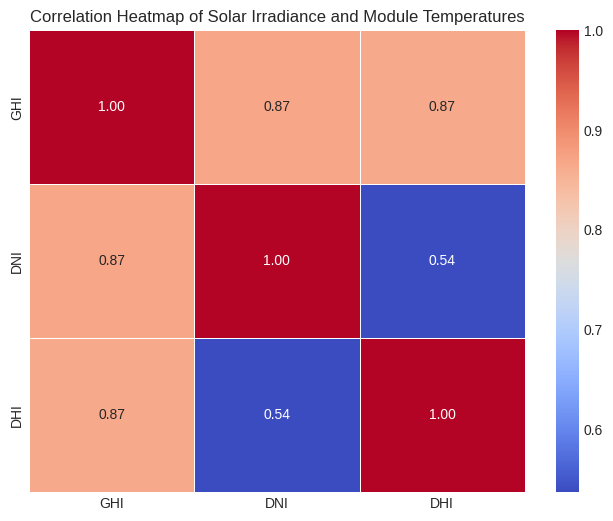

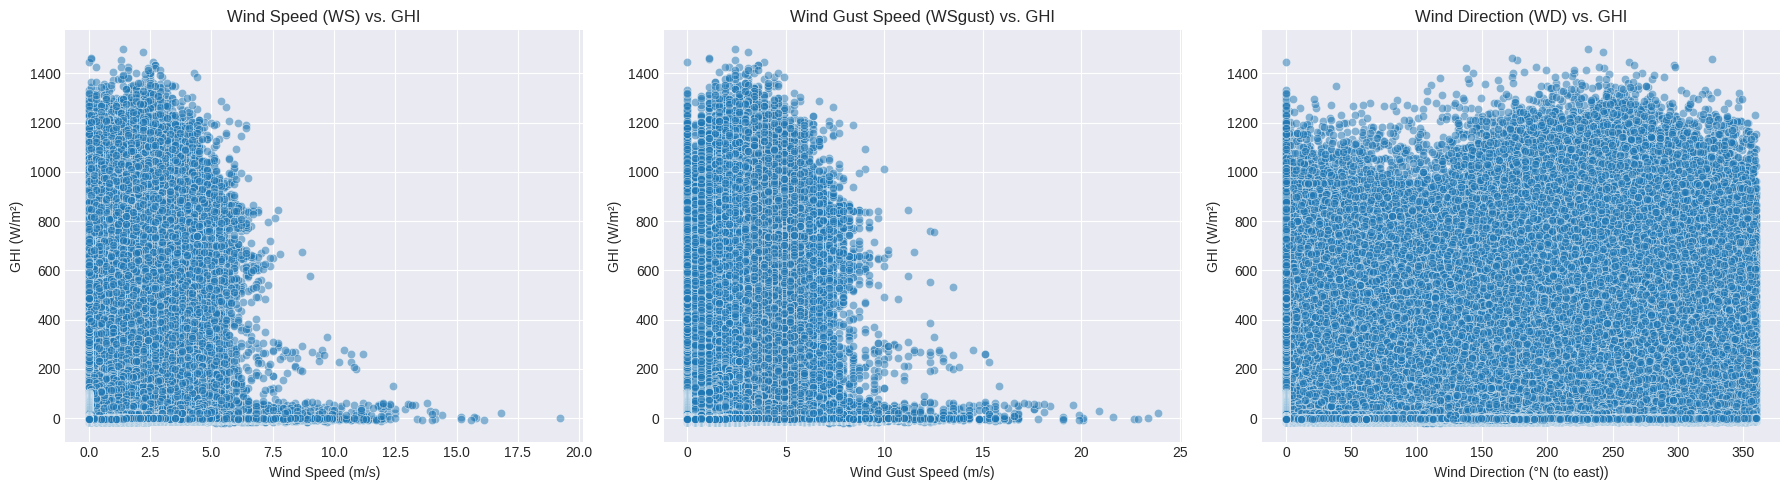

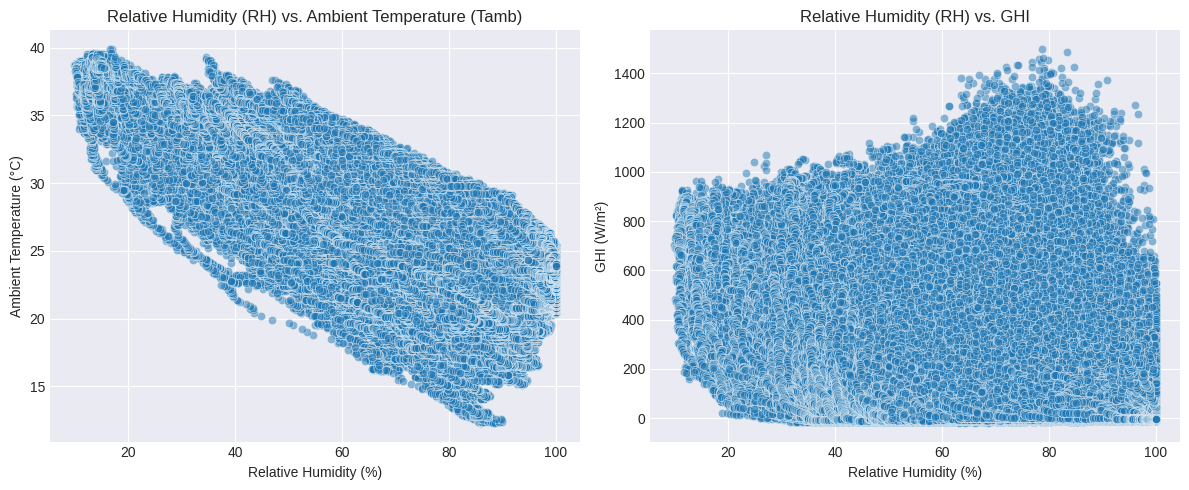

In [14]:
# --- 5. Correlation & Relationship Analysis ---
print("\n--- 5. Correlation & Relationship Analysis ---")

correlation_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
correlation_cols = [col for col in correlation_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

if len(correlation_cols) > 1:
    correlation_matrix = df[correlation_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Solar Irradiance and Module Temperatures')
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap among GHI, DNI, DHI, TModA, TModB.")


# Scatter plots: WS, WSgust, WD vs. GHI; RH vs. Tamb or RH vs. GHI.

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='WS', y='GHI', data=df, alpha=0.5)
plt.title('Wind Speed (WS) vs. GHI')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')

plt.subplot(1, 3, 2)
sns.scatterplot(x='WSgust', y='GHI', data=df, alpha=0.5)
plt.title('Wind Gust Speed (WSgust) vs. GHI')
plt.xlabel('Wind Gust Speed (m/s)')
plt.ylabel('GHI (W/m²)')

# **FIX FOR TYPERROR HERE:** Ensure 'WD' is numeric before plotting
if 'WD' in df.columns:
    df['WD'] = pd.to_numeric(df['WD'], errors='coerce') 
    if df['WD'].isnull().any():
        print(f"Warning: 'WD' column contains NaN values. Imputing with median for plotting.")
        df['WD'].fillna(df['WD'].median(), inplace=True) # Fill NaNs for plot consistency

plt.subplot(1, 3, 3)
sns.scatterplot(x='WD', y='GHI', data=df, alpha=0.5)
plt.title('Wind Direction (WD) vs. GHI')
plt.xlabel('Wind Direction (°N (to east))')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()

if 'RH' in df.columns:
    df['RH'] = pd.to_numeric(df['RH'], errors='coerce')
    if df['RH'].isnull().any():
        print(f"Warning: 'WD' column contains NaN values. Imputing with median for plotting.")
        df['RH'].fillna(df['RH'].median(), inplace=True) # Fill NaNs for plot consistency

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='RH', y='Tamb', data=df, alpha=0.5)
plt.title('Relative Humidity (RH) vs. Ambient Temperature (Tamb)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='RH', y='GHI', data=df, alpha=0.5)
plt.title('Relative Humidity (RH) vs. GHI')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()


--- 6. Wind & Distribution Analysis ---
Windrose library not installed. Skipping wind rose plot. Install with: pip install windrose


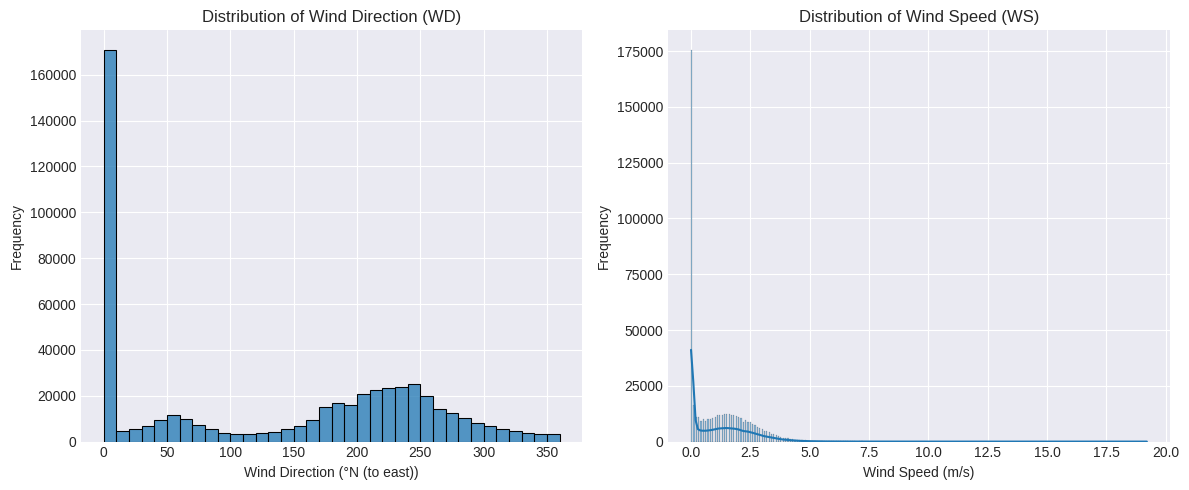

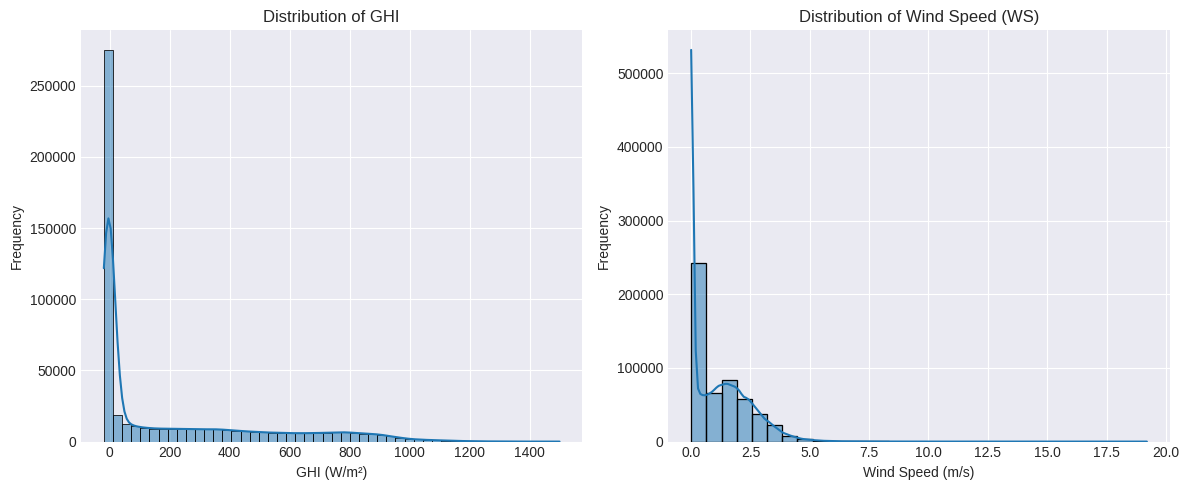

In [15]:
# --- 6. Wind & Distribution Analysis ---
print("\n--- 6. Wind & Distribution Analysis ---")

try:
    from windrose import WindroseAxes
    # Ensure WD and WS are numeric and handle NaNs for windrose
    if 'WD' in df.columns and 'WS' in df.columns:
        df_windrose = df[['WD', 'WS']].dropna()
        if not df_windrose.empty:
            fig = plt.figure(figsize=(10, 10))
            ax = WindroseAxes.from_ax(fig=fig)
            ax.bar(df_windrose['WD'], df_windrose['WS'], normed=True, opening=0.8, edgecolor='white')
            ax.set_legend()
            plt.title('Wind Rose of Wind Speed and Direction')
            plt.show()
        else:
            print("No valid data for Wind Rose plot after dropping NaNs.")
    else:
        print("WD or WS columns not found for Wind Rose plot.")
except ImportError:
    print("Windrose library not installed. Skipping wind rose plot. Install with: pip install windrose")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['WD'], bins=36, kde=False)
    plt.title('Distribution of Wind Direction (WD)')
    plt.xlabel('Wind Direction (°N (to east))')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df['WS'], kde=True)
    plt.title('Distribution of Wind Speed (WS)')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['GHI'].dropna(), kde=True, bins=50)
plt.title('Distribution of GHI')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['WS'].dropna(), kde=True, bins=30)
plt.title('Distribution of Wind Speed (WS)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


--- 7. Temperature Analysis ---


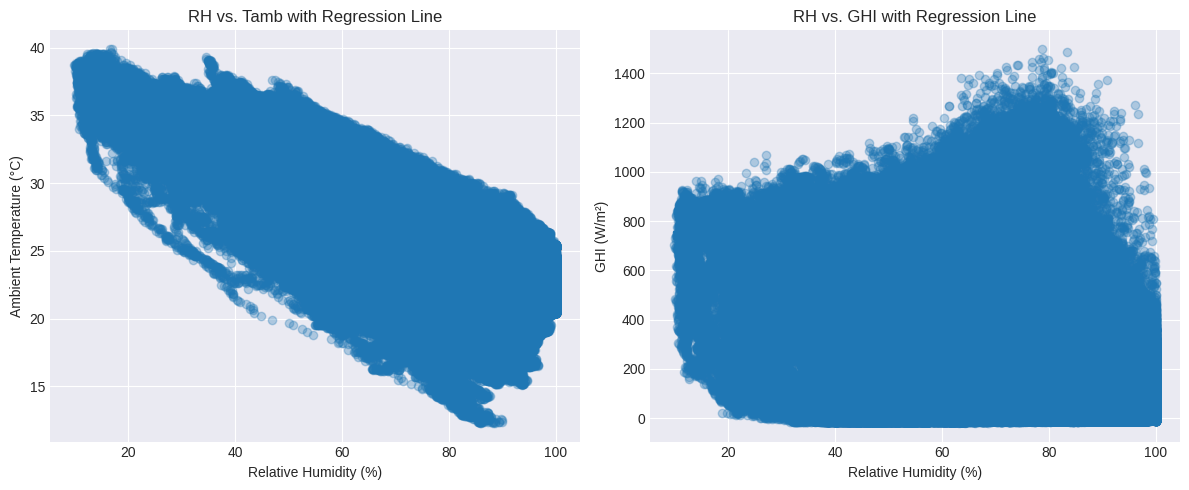

Observations: High humidity might correlate with lower temperatures or lower solar radiation (due to clouds/atmospheric conditions).


In [16]:
# --- 7. Temperature Analysis ---
print("\n--- 7. Temperature Analysis ---")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.regplot(x='RH', y='Tamb', data=df, scatter_kws={'alpha':0.3})
plt.title('RH vs. Tamb with Regression Line')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')

plt.subplot(1, 2, 2)
sns.regplot(x='RH', y='GHI', data=df, scatter_kws={'alpha':0.3})
plt.title('RH vs. GHI with Regression Line')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()

print("Observations: High humidity might correlate with lower temperatures or lower solar radiation (due to clouds/atmospheric conditions).")



--- 8. Bubble Chart ---
Using Barometric Pressure (BP) for bubble size.


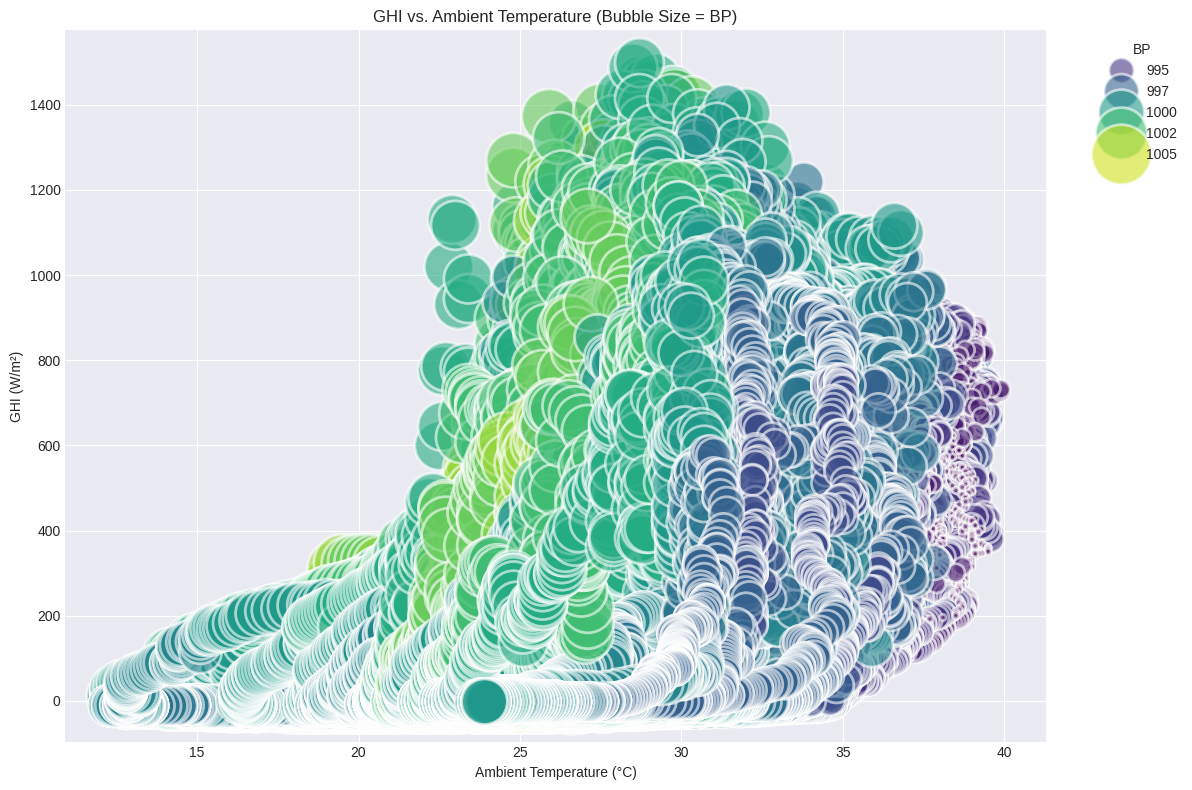


--- EDA Complete ---


In [17]:
# --- 8. Bubble Chart ---
print("\n--- 8. Bubble Chart ---")

if 'BP' in df.columns:
    df['BP'] = pd.to_numeric(df['BP'], errors='coerce')
    if df['BP'].isnull().any():
        print(f"Warning: 'WD' column contains NaN values. Imputing with median for plotting.")
        df['BP'].fillna(df['BP'].median(), inplace=True) # Fill NaNs for plot consistency

bubble_size_col = 'RH'
if 'BP' in df.columns and not df['BP'].isnull().all() and (df['BP'] >= 0).all(): # Check if BP is valid and non-negative
    bubble_size_col = 'BP'
    print(f"Using Barometric Pressure ({bubble_size_col}) for bubble size.")
else:
    print(f"Using Relative Humidity ({bubble_size_col}) for bubble size (BP not suitable).")

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Tamb', y='GHI', size=bubble_size_col, hue=bubble_size_col,
                data=df, sizes=(20, 2000), alpha=0.6, palette='viridis')
plt.title(f'GHI vs. Ambient Temperature (Bubble Size = {bubble_size_col})')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.legend(title=bubble_size_col, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- EDA Complete ---")